In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

#importing models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# importing feature engineering tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error


#Importing model selection tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn import set_config


In [2]:
df = pd.read_csv("./data/train.csv", parse_dates=True, index_col= 0)


In [3]:
# extract information from datetime column
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

In [4]:
ordered_cols = ['year', 'month', 'week', 'day_of_week', 
                'day', 'hour', 'season', 'holiday', 'workingday', 
                'weather', 'temp', 'atemp', 'humidity', 'windspeed']
X = df[ordered_cols]
y = df['count']
logy_plus_1 = np.log(df['count']+1)
X.loc[:,'day_of_week'] += 1

/home/cubo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### exploratory analysis

In [5]:
X.dtypes

year             int64
month            int64
week            UInt32
day_of_week      int64
day              int64
hour             int64
season           int64
holiday          int64
workingday       int64
weather          int64
temp           float64
atemp          float64
humidity         int64
windspeed      float64
dtype: object

In [6]:
#X.head()

In [7]:
feb_19_2011df = X.loc[(X['day']==19) & (X['month'] == 2) 
                    & (X['year'] == 2011)]
f_19_2011_y = y.loc['2011-02-19']
#f_19_2011_y

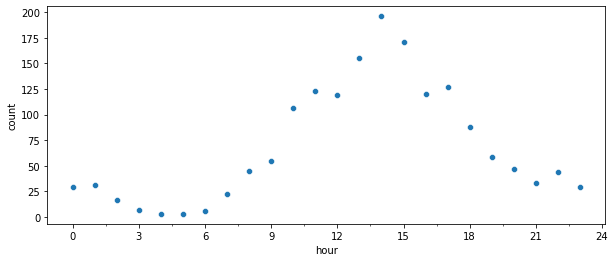

In [8]:
fig, ax = plt.subplots(figsize = (10,4))
sns.scatterplot(data=feb_19_2011df, 
                x=feb_19_2011df['hour'], y=f_19_2011_y)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(plt.MaxNLocator(20))

In [9]:
w2_2011df = df.loc[(df['week'] ==2) & (df['year'] == 2011)]
sumW2_2011 = w2_2011df.groupby('day')['count'].sum()
#sumW2_2011

w2_2012df = df.loc[(df['week'] ==2) & (df['year'] == 2012)]
sumW2_2012 = w2_2012df.groupby('day')['count'].sum()
#sumW2_2012
#week_df

In [10]:
#week_df['day'].unique()

Text(0.5, 1.0, 'Sum of hirers for week 2 of 2011 (Mon-Sun)')

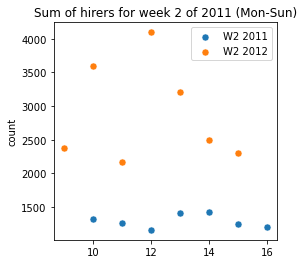

In [11]:
fig, ax = plt.subplots(figsize = (4,4))
sns.scatterplot(x = w2_2011df['day'].unique(),
                y=sumW2_2011, s=50, label='W2 2011')
sns.scatterplot(x = w2_2012df['day'].unique(), 
                y=sumW2_2012, s=50, label='W2 2012')
plt.title('Sum of hirers for week 2 of 2011 (Mon-Sun)')

In [12]:
sumPerMonths2011 = df.loc[X['year']==2011].groupby('month')['count'].sum()
sumPerMonths2012 = df.loc[X['year']==2012].groupby('month')['count'].sum()
sumPerMonths2011

month
1     23552
2     32844
3     38735
4     50517
5     79713
6     89776
7     92848
8     83296
9     79104
10    79522
11    70889
12    61183
Name: count, dtype: int64

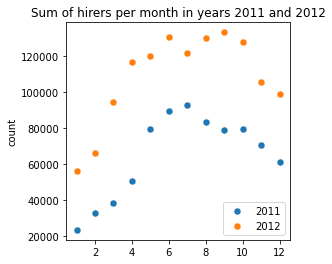

In [13]:
fig, ax = plt.subplots(figsize = (4,4))
sns.scatterplot(x = X['month'].unique(), y=sumPerMonths2011, s=50, label='2011')
sns.scatterplot(x = X['month'].unique(), y=sumPerMonths2012, s=50, label='2012')
plt.title('Sum of hirers per month in years 2011 and 2012')
ax.legend(loc = 'lower right')

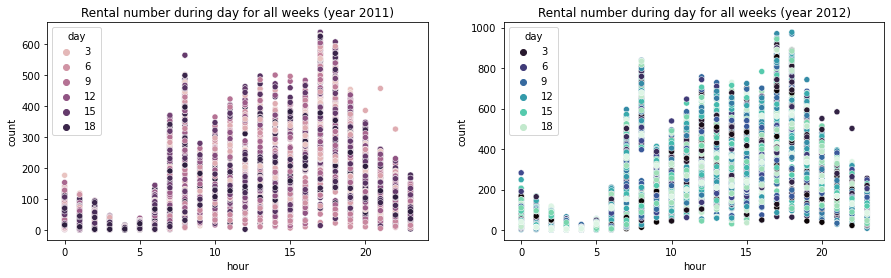

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
week_df2011 = df.loc[(df['week'] >1) & (df['year'] == 2011)]
week_df2012 = df.loc[(df['week'] >1) & (df['year'] == 2012)]
#col = sns.color_palette("light:#5A9", as_cmap=True)
col = sns.color_palette("mako", as_cmap=True)
sns.scatterplot( data= week_df2011, x=week_df2011['hour'], y=week_df2011['count'],
                hue='day', ax=axs[0])
axs[0].title.set_text('Rental number during day for all weeks (year 2011)')

sns.scatterplot( data= week_df2012, x=week_df2012['hour'], y=week_df2012['count'],
                hue='day', ax=axs[1], palette=col)
axs[1].title.set_text('Rental number during day for all weeks (year 2012)')
# Question: how can I spread the values

In [15]:
# There are not missing values
X.isna().sum()

#for col in ordered_cols:
#    print(col, '\t\t missed values?\t\t', X[col].isnull().values.any())

year           0
month          0
week           0
day_of_week    0
day            0
hour           0
season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
dtype: int64

In [16]:
#X.iloc[9900:9930]
X['windspeed'].min()

0.0

#### Feature engineering

In [17]:
# divide in training and verification data
X_t, X_v, logy_t, logy_v = train_test_split(X, logy_plus_1)
y_t = np.exp(logy_t) -1
y_v = np.exp(logy_v) -1

In [18]:
feat_eng = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday', 'workingday']),
    ('bins', KBinsDiscretizer(n_bins = 4), ['temp', 'atemp', 'windspeed']),
    ('scaleHum', MinMaxScaler(), ['humidity']),
    ('hotSeas', OneHotEncoder(sparse=False,handle_unknown='ignore'), ['season', 'weather']),
    ('hotYear', OneHotEncoder(sparse=False,handle_unknown='ignore'), ['year'])
    ],
    remainder='drop')

In [19]:
##feat_eng.fit(X)
# tranform
#X_trans =  feat_eng.transform(X)
#X_transDF = pd.DataFrame(X_trans)
#X_transDF

In [20]:
model_pipeline = make_pipeline(feat_eng, LinearRegression())

In [21]:
# see the pipeline workflow
set_config(display='diagram')
#model_pipeline

In [22]:
# Fitting the model using logy_plus_1 = ln(y+1)
model_pipeline.fit(X_t,logy_t)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['holiday', 'workingday']),
                                                 ('bins',
                                                  KBinsDiscretizer(n_bins=4),
                                                  ['temp', 'atemp',
                                                   'windspeed']),
                                                 ('scaleHum', MinMaxScaler(),
                                                  ['humidity']),
                                                 ('hotSeas',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['season', 'weather']),
                                                 ('hotYear',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year'])])),
                ('linearregression', LinearRegression())])

In [23]:
# Predict training data
logy_pred_t = model_pipeline.predict(X_t)

In [24]:
for e in logy_pred_t:
    if e < 0:
        print('ATTENTION')
y_pred_t = np.exp(logy_pred_t) -1

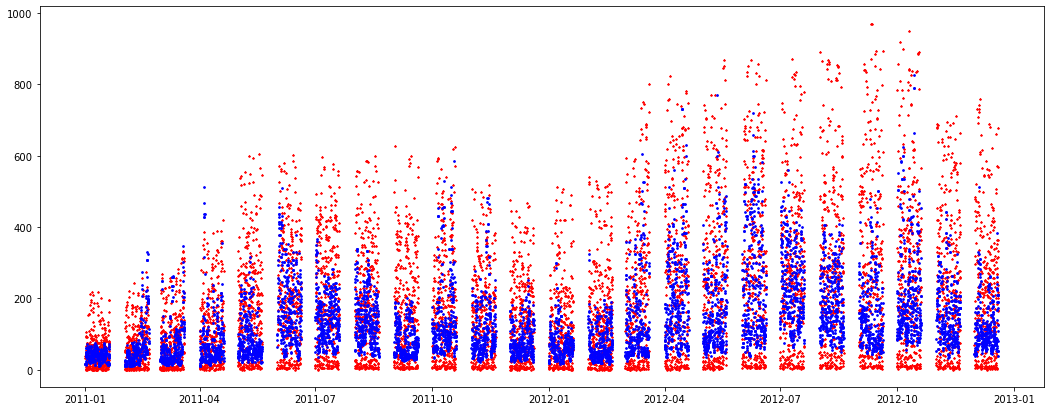

In [25]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_t.index[::every], y_t[::every], s=3, marker = '*', c='red')
plt.scatter(X_t.index[::every], y_pred_t[::every], c='blue', s=3)

In [26]:
mse_t = mean_squared_error(y_t, y_pred_t)
mse_t

26258.259203002213

In [27]:
r2_t = r2_score(y_t, y_pred_t)
r2_t

0.19790956599085952

In [28]:
msle_t = mean_squared_log_error(y_t, y_pred_t)
msle_t

1.4428100510762814

In [29]:
#X_v

In [30]:
logy_pred_v = model_pipeline.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1

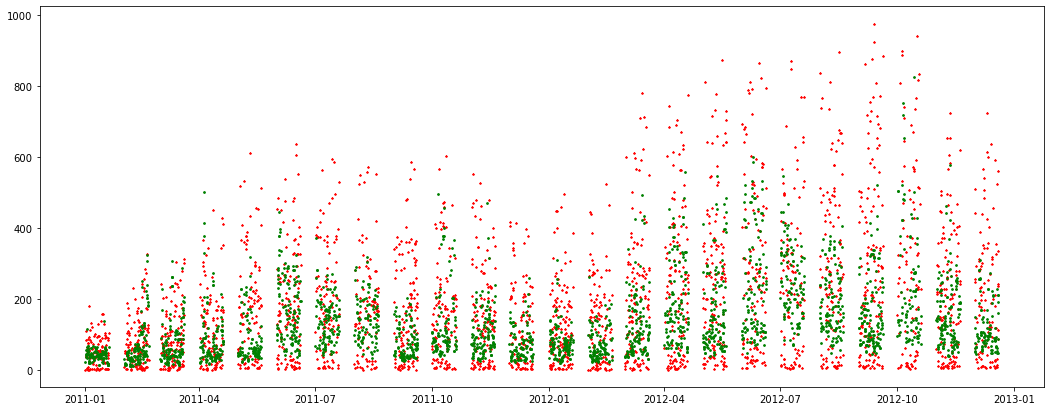

In [31]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_v.index[::every], y_v[::every], s=3, marker = '*', c='red')
plt.scatter(X_v.index[::every], y_pred_v[::every], c='green', s=3)

In [32]:
for e in y_pred_v:
    if e < 0:
        print('ATTENTION')
#y_pred_v = np.exp(logy_pred_v) -1

In [33]:
mse_v = mean_squared_error(y_v, y_pred_v)
mse_v

25277.826196478833

In [34]:
r2_v = r2_score(y_v, y_pred_v)
r2_v

0.2346357549184872

In [35]:
msle_v = mean_squared_log_error(y_v, y_pred_v)
msle_v

1.398524693761718

In [36]:
err_t_LR_simple = [mse_t, r2_t, msle_t]
err_v_LR_simple = [mse_v, r2_v, msle_v]

#### New feature engineering considering Polynomial Transformation and Interactions

In [37]:
interactionDeg2 = PolynomialFeatures(degree=2, 
                   interaction_only=True, include_bias=False)

In [38]:
feat_eng = ColumnTransformer([
    ('weekDay*Hour', make_pipeline(interactionDeg2, MinMaxScaler()),
                                        ['day_of_week', 'hour']),
    ('do_nothing', 'passthrough', ['holiday', 'workingday']),
    ('bins', KBinsDiscretizer(n_bins = 4), ['temp', 'atemp', 'windspeed']),
    #('binHours', KBinsDiscretizer(n_bins=6, strategy='uniform'), ['hour']),
    ('scaleHum', MinMaxScaler(), ['humidity']),
    ('hotSeas', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'weather']),
    ('hotYear', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['year'])
    ],
    remainder='drop')

In [39]:
#X_t

In [40]:
model_pipeline = make_pipeline(feat_eng, LinearRegression())

In [41]:
# Fitting the model using logy_plus_1 = ln(y+1)
mfitted = model_pipeline.fit(X_t,logy_t)
#X_t_trans = feat_eng.transform(X_t)
#X_t_trans_df = pd.DataFrame(X_t_trans)
#X_t_trans_df

In [42]:
# Predict training data
logy_pred_t = model_pipeline.predict(X_t)
y_pred_t = np.exp(logy_pred_t) - 1

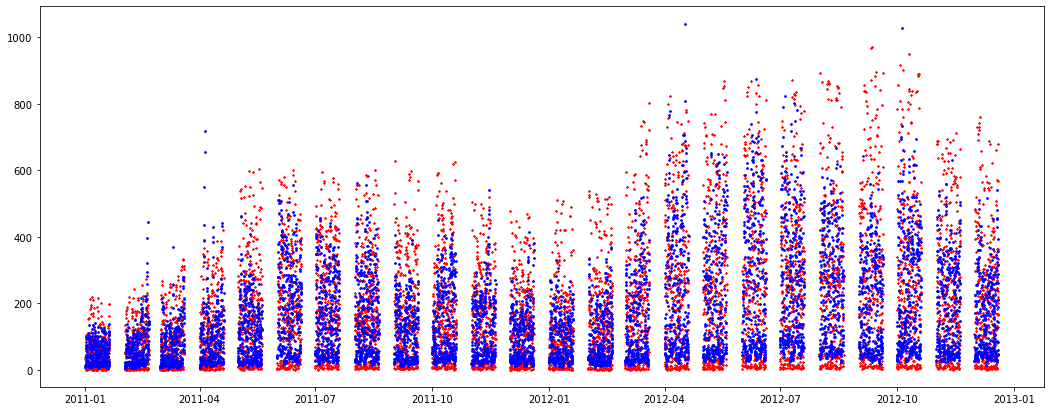

In [43]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_t.index[::every], y_t[::every], s=3, marker = '*', c='red')
plt.scatter(X_t.index[::every], y_pred_t[::every], c='blue', s=3)

In [44]:
mse_t = mean_squared_error(y_t, y_pred_t)
mse_t

25621.645392716062

In [45]:
r2_t = r2_score(y_t, y_pred_t)
r2_t

0.21735570838137452

In [46]:
msle_t = mean_squared_log_error(y_t, y_pred_t)
msle_t

1.0289696218843627

In [47]:
# Predict on Verification data

In [48]:
logy_pred_v = model_pipeline.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1

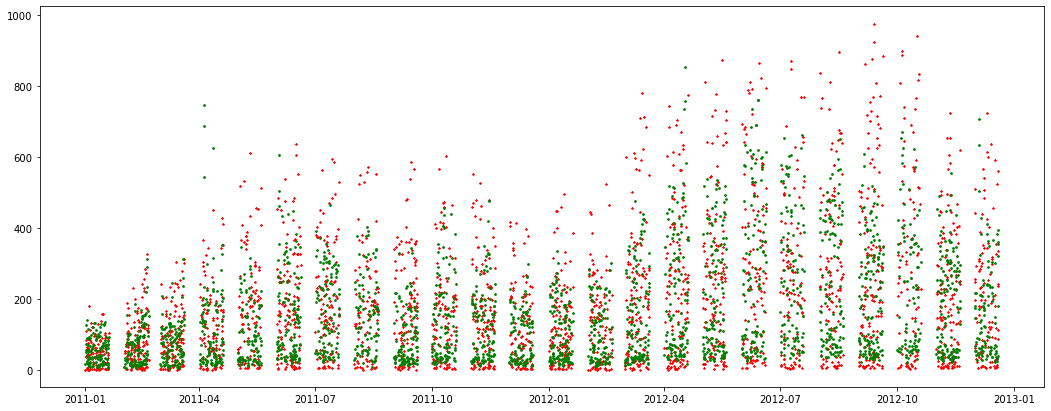

In [49]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_v.index[::every], y_v[::every], s=3, marker = '*', c='red')
plt.scatter(X_v.index[::every], y_pred_v[::every], c='green', s=3)

In [50]:
mse_v = mean_squared_error(y_v, y_pred_v)
mse_v

24725.370737115478

In [51]:
r2_v = r2_score(y_v, y_pred_v)
r2_v

0.2513630499125359

In [52]:
msle_v = mean_squared_log_error(y_v, y_pred_v)
msle_v

0.9657318484385814

In [53]:
err_t_LR_polyF = [mse_t, r2_t, msle_t]
err_v_LR_polyF = [mse_v, r2_v, msle_v]

#### Comparison of LR model with different feature engineering  characteristics, for training and verification data

In [54]:
scoreDic = {'mse_t':[err_t_LR_simple[0], err_t_LR_polyF[0]],
            'r2_t':[err_t_LR_simple[1], err_t_LR_polyF[1]],
            'msle_t':[err_t_LR_simple[2], err_t_LR_polyF[2]],
            'mse_v':[err_v_LR_simple[0], err_v_LR_polyF[0]],
            'r2_v':[err_v_LR_simple[1], err_v_LR_polyF[1]],
            'msle_v':[err_v_LR_simple[2], err_v_LR_polyF[2]],
           }
labels = ['simpleLR', 'LR_withPolyF']

scoreDF = pd.DataFrame(scoreDic, index=labels)
scoreDF

,mse_t,r2_t,msle_t,mse_v,r2_v,msle_v
simpleLR,26258.259203,0.197910,1.44281,25277.826196,0.234636,1.398525
LR_withPolyF,25621.645393,0.217356,1.02897,24725.370737,0.251363,0.965732


In [55]:
scoreDF.reset_index(inplace = True)
scoreDF

,index,mse_t,r2_t,msle_t,mse_v,r2_v,msle_v
0,simpleLR,26258.259203,0.197910,1.44281,25277.826196,0.234636,1.398525
1,LR_withPolyF,25621.645393,0.217356,1.02897,24725.370737,0.251363,0.965732


In [56]:
meltScore = scoreDF.melt(id_vars='index', 
                         var_name='type_err', 
                         value_name='scores')
#meltScore
meltS_MSE = meltScore.loc[(meltScore['type_err'] == 'mse_t') 
                         | (meltScore['type_err'] == 'mse_v')]

meltS_MSLE = meltScore.loc[(meltScore['type_err'] == 'msle_t') 
                         | (meltScore['type_err'] == 'msle_v')]

meltS_r2 = meltScore.loc[(meltScore['type_err'] == 'r2_t') 
                         | (meltScore['type_err'] == 'r2_v')]
meltS_MSE

,index,type_err,scores
0,simpleLR,mse_t,26258.259203
1,LR_withPolyF,mse_t,25621.645393
6,simpleLR,mse_v,25277.826196
7,LR_withPolyF,mse_v,24725.370737


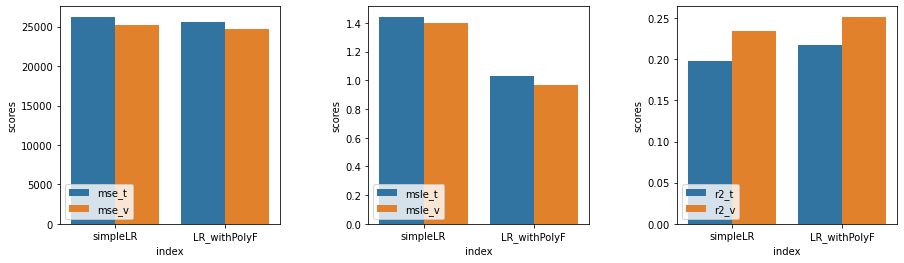

In [57]:
fig, axs = plt.subplots(1,3, figsize = (15,4))
sns.barplot(x='index', y='scores', 
                     hue= 'type_err', data=meltS_MSE, 
                     ax = axs[0])
sns.barplot(x='index', y='scores', 
                     hue= 'type_err', data=meltS_MSLE, 
                     ax = axs[1])
sns.barplot(x='index', y='scores', 
                     hue= 'type_err', data=meltS_r2)
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
axs[2].legend(loc='lower left')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

### Regularization and Hyperparameter optimization

interactionDeg2 = PolynomialFeatures( 
                   interaction_only=True, include_bias=False)

In [58]:
feat_eng = ColumnTransformer([
    ('weekDay*Hour', make_pipeline(interactionDeg2, MinMaxScaler()),
                                        ['day_of_week', 'hour']),
    ('do_nothing', 'passthrough', ['holiday', 'workingday']),
    ('bins', KBinsDiscretizer(encode='ordinal', strategy='uniform'), ['temp', 'atemp', 'windspeed']),
    #('binHours', KBinsDiscretizer(encode='ordinal', strategy='uniform'), ['hour']),
    ('scaleHum', MinMaxScaler(), ['humidity']),
    ('hotSeas', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'weather']),
    ('hotYear', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['year'])
    ],
    remainder='drop')

#### Using Ridge regularization

In [59]:
model_pipeRidge = make_pipeline(feat_eng, Ridge(max_iter=10000))
model_pipeRidge.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('weekDay*Hour',
                                    Pipeline(steps=[('polynomialfeatures',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True)),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['day_of_week', 'hour']),
                                   ('do_nothing', 'passthrough',
                                    ['holiday', 'workingday']),
                                   ('bins',
                                    KBinsDiscretizer(encode='ordinal',
                                                     strategy='uniform'),
                                    ['temp', 'atemp', 'windspeed']),
                                   ('scaleHu

In [60]:
# Find the best parameters for the model
param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,3],
    'columntransformer__bins__n_bins':[3, 4, 6]
            }

In [61]:
#initiate model
scorings = ['r2', 'neg_root_mean_squared_error',
            'neg_mean_squared_log_error']
grid_search = GridSearchCV(
    estimator=model_pipeRidge, 
    param_grid=param_grid, 
    cv=5, 
    return_train_score=True, 
    scoring= 'neg_mean_squared_log_error',
    n_jobs=4 # use all 4 CPU cores in parallel
)

In [62]:
# Fit the grid search model
grid_search.fit(X_t, logy_t)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('weekDay*Hour',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday',
                                                                          'workingday']),
                                                                        ('bins',
                                                                         KBinsDiscretizer(...
                                                                          'weather']),
                                                                        ('hotYear',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['year'])])),
                                       ('ridge', Ridge(max_iter=10000))]),
             n_jobs=4,
             param_grid={'columntransformer__bins__n_bins': [3, 4, 6],
                         'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,
                                                                                         3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [63]:
# best parameters
grid_search.best_params_  

{'columntransformer__bins__n_bins': 6,
 'columntransformer__weekDay*Hour__polynomialfeatures__degree': 2,
 'ridge__alpha': 0.001}

In [64]:
cv_results = pd.DataFrame(grid_search.cv_results_)
#cv_results
# select intresting columns
#cv_results[['param_ridge__alpha',
#    'param_columntransformer__weekDay*Hour__polynomialfeatures__degree',
#    'param_columntransformer__bins__n_bins', 
#    'mean_train_score', 
#    'mean_test_score']]

In [65]:
# select the best model and calculate predictions on the test data
logy_pred_v = grid_search.best_estimator_.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1



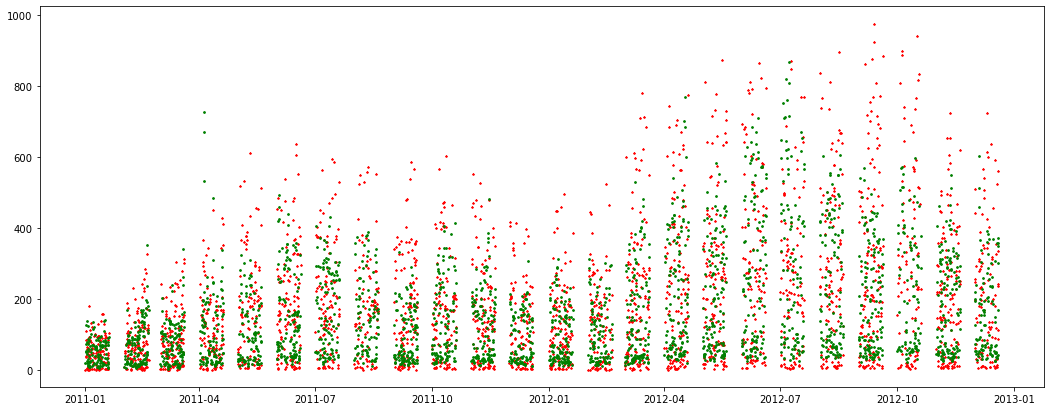

In [66]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_v.index[::every], y_v[::every], s=3, marker = '*', c='red')
plt.scatter(X_v.index[::every], y_pred_v[::every], c='green', s=3)

In [67]:
mse_v = mean_squared_error(y_v, y_pred_v)
r2_v = r2_score(y_v, y_pred_v)
msle_v = mean_squared_log_error(y_v, y_pred_v)
err_v_LR_best_est = [mse_v, r2_v, msle_v]

In [68]:
print(err_v_LR_best_est)

[25223.754469679745, 0.23627294341880223, 0.9668948448294926]


#### Using RandomForestRegressor

In [69]:
model_pipeRF = make_pipeline(feat_eng, RandomForestRegressor())
model_pipeRF.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('weekDay*Hour',
                                    Pipeline(steps=[('polynomialfeatures',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True)),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['day_of_week', 'hour']),
                                   ('do_nothing', 'passthrough',
                                    ['holiday', 'workingday']),
                                   ('bins',
                                    KBinsDiscretizer(encode='ordinal',
                                                     strategy='uniform'),
                                    ['temp', 'atemp', 'windspeed']),
                                   ('scaleHu

In [70]:
# Find the best parameters for the model
param_grid_RF = {
    'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,3],
    'columntransformer__bins__n_bins':[3, 4, 6],
    'randomforestregressor__max_depth':[256, 512],
    'randomforestregressor__n_estimators': [100, 150],
    #'randomforestregressor__criterion': ['mse', 'mae']
            }

In [71]:
grid_search_RF = GridSearchCV(
    estimator=model_pipeRF, 
    param_grid=param_grid_RF, 
    cv=5, 
    return_train_score=True, 
    scoring= 'neg_mean_squared_log_error',
    n_jobs=4 # use all 4 CPU cores in parallel
)

In [72]:
# Fit the grid search model
grid_search_RF.fit(X_t, logy_t)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('weekDay*Hour',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday',
                                                                          'workingday']),
                                                                        ('bins',
                                                                         KBinsDiscretizer(...
                                                                         ['year'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'columntransformer__bins__n_bins': [3, 4, 6],
                         'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,
                                                                                         3],
                         'randomforestregressor__max_depth': [256, 512],
                         'randomforestregressor__n_estimators': [100, 150]},
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [73]:
# best parameters
bestPars = grid_search_RF.best_params_ 

In [74]:
cv_results_RF = pd.DataFrame(grid_search_RF.cv_results_)
#cv_results_RF[[
#    'param_columntransformer__weekDay*Hour__polynomialfeatures__degree',
#    'param_columntransformer__bins__n_bins', 
#    'param_randomforestregressor__max_depth',
#    'param_randomforestregressor__n_estimators'
#    'mean_train_score', 
#    'mean_test_score']]

In [75]:
# select the best model and calculate predictions on the test data
logy_pred_v = grid_search_RF.best_estimator_.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1

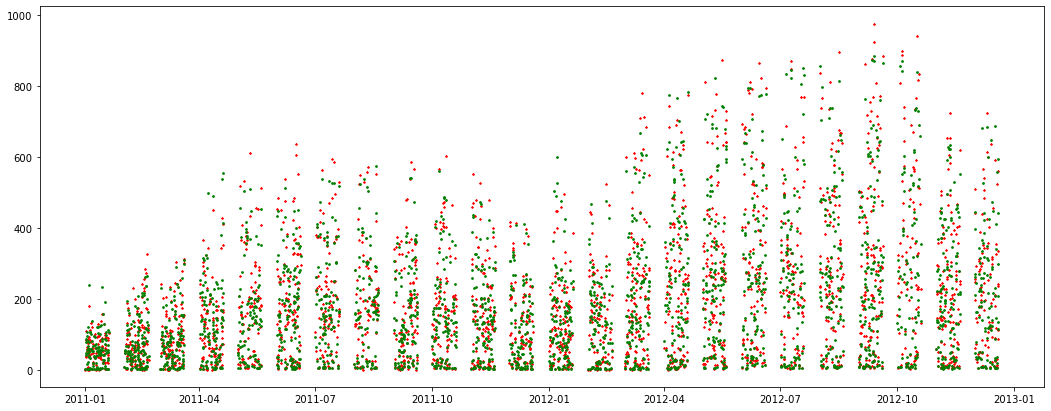

In [76]:
every = 1
fig, ax = plt.subplots(figsize=(18,7))
plt.scatter(X_v.index[::every], y_v[::every], s=3, marker = '*', c='red')
plt.scatter(X_v.index[::every], y_pred_v[::every], c='green', s=3)

In [77]:
mse_v = mean_squared_error(y_v, y_pred_v)
r2_v = r2_score(y_v, y_pred_v)
msle_v = mean_squared_log_error(y_v, y_pred_v)
err_v_RF_best_est = [mse_v, r2_v, msle_v]

In [78]:
err_v_RF_best_est

[1954.7773954640643, 0.9408130780727432, 0.10377102773048998]

#### adding binHours to feat_eng to use in random forest

In [79]:
feat_eng = ColumnTransformer([
    ('weekDay*Hour', make_pipeline(interactionDeg2, MinMaxScaler()),
                                        ['day_of_week', 'hour']),
    ('do_nothing', 'passthrough', ['holiday', 'workingday']),
    ('bins', KBinsDiscretizer(encode='ordinal', strategy='uniform'), ['temp', 'atemp', 'windspeed']),
    ('binHours', KBinsDiscretizer(encode='ordinal', strategy='uniform'), ['hour']),
    ('scaleHum', MinMaxScaler(), ['humidity']),
    ('hotSeas', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'weather']),
    ('hotYear', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['year'])
    ],
    remainder='drop')

In [80]:
model_pipeRF_plus = make_pipeline(feat_eng, RandomForestRegressor())
model_pipeRF_plus.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('weekDay*Hour',
                                    Pipeline(steps=[('polynomialfeatures',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True)),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['day_of_week', 'hour']),
                                   ('do_nothing', 'passthrough',
                                    ['holiday', 'workingday']),
                                   ('bins',
                                    KBinsDiscretizer(encode='ordinal',
                                                     strategy='uniform'),
                                    ['temp', 'atemp', 'windspeed']),
                                   ('binHour

In [81]:
# Find the best parameters for the model
param_grid_RF_plus = {
    'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,3],
    'columntransformer__bins__n_bins':[3, 4, 6],
    'columntransformer__binHours__n_bins':[6,12],
    'randomforestregressor__max_depth':[256, 512],
    'randomforestregressor__n_estimators': [100, 150],
    #'randomforestregressor__criterion': ['mse', 'mae']
            }

In [82]:
grid_search_RF_plus = GridSearchCV(
    estimator=model_pipeRF_plus, 
    param_grid=param_grid_RF_plus, 
    cv=5, 
    return_train_score=True, 
    scoring= 'neg_mean_squared_log_error',
    n_jobs=4 # use all 4 CPU cores in parallel
)

In [83]:
# Fit the grid search model
grid_search_RF_plus.fit(X_t, logy_t)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('weekDay*Hour',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday',
                                                                          'workingday']),
                                                                        ('bins',
                                                                         KBinsDiscretizer(...
                                        RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'columntransformer__binHours__n_bins': [6, 12],
                         'columntransformer__bins__n_bins': [3, 4, 6],
                         'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,
                                                                                         3],
                         'randomforestregressor__max_depth': [256, 512],
                         'randomforestregressor__n_estimators': [100, 150]},
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [84]:
# best parameters
bestPars = grid_search_RF_plus.best_params_ 
bestPars

{'columntransformer__binHours__n_bins': 12,
 'columntransformer__bins__n_bins': 4,
 'columntransformer__weekDay*Hour__polynomialfeatures__degree': 2,
 'randomforestregressor__max_depth': 256,
 'randomforestregressor__n_estimators': 150}

In [85]:
cv_results_RF_plus = pd.DataFrame(grid_search_RF.cv_results_)
#cv_results_RF_plus[[
#    'param_columntransformer__weekDay*Hour__polynomialfeatures__degree',
#    'param_columntransformer__bins__n_bins', 
#    'columntransformer__binHours__n_bins',
#    'param_randomforestregressor__max_depth',
#    'param_randomforestregressor__n_estimators'
#    'mean_train_score', 
#    'mean_test_score']]

In [86]:
# select the best model and calculate predictions on the test data
logy_pred_v = grid_search_RF_plus.best_estimator_.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1

In [87]:
mse_v = mean_squared_error(y_v, y_pred_v)
r2_v = r2_score(y_v, y_pred_v)
msle_v = mean_squared_log_error(y_v, y_pred_v)
err_v_RF_plus_best_est = [mse_v, r2_v, msle_v]

In [88]:
err_v_RF_plus_best_est

[1971.3933542066047, 0.9403099786123528, 0.10343942725488531]

#### Comparison LR with two RF (RF and RF_plus)
- Note: RF_plus is nothing else as RF only with a feature expansion more. This added feature expansion is a KBinsDiscretizer for hours 

In [89]:
scoreDic = {
            'MSE':[err_v_LR_best_est[0], err_v_RF_best_est[0],
                    err_v_RF_plus_best_est[0]],
            'r2_score':[err_v_LR_best_est[1], err_v_RF_best_est[1],
                    err_v_RF_plus_best_est[1]],
            'RMSLE': [np.sqrt(err_v_LR_best_est[2]), 
                     np.sqrt(err_v_RF_best_est[2]),
                     np.sqrt(err_v_RF_plus_best_est[2])]
           }
labels = ['Ridge', 'RF', 'RF_plus']

scoreDF = pd.DataFrame(scoreDic, index=labels)
scoreDF

,MSE,r2_score,RMSLE
Ridge,25223.754470,0.236273,0.983308
RF,1954.777395,0.940813,0.322135
RF_plus,1971.393354,0.940310,0.321620


RMSLE: Root mean Squared Logarithmic Error (used in Kaggle)
$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } 
$$

Text(0.5, 0.98, 'Comparison between RIDGE, RF and RF_plus  (i.e with added features)')

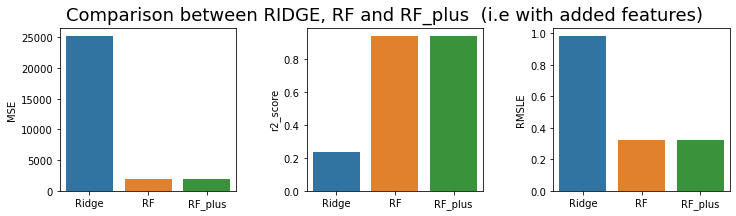

In [90]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=scoreDF, x=scoreDF.index, y='MSE', ax = axs[0])
sns.barplot(data=scoreDF, x=scoreDF.index, y='r2_score', ax = axs[1])
sns.barplot(data=scoreDF, x=scoreDF.index, y='RMSLE', ax = axs[2])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
fig.suptitle('Comparison between RIDGE, RF and RF_plus  (i.e with added features)',
            size=18)

### Boosted Tree

In [91]:
feat_eng = ColumnTransformer([
    ('weekDay*Hour', make_pipeline(interactionDeg2, MinMaxScaler()),
                                        ['day_of_week', 'hour']),
    ('do_nothing', 'passthrough', ['holiday', 'workingday']),
    ('bins', KBinsDiscretizer(encode='ordinal', strategy='uniform'), ['temp', 'atemp', 'windspeed']),
    ('scaleHum', MinMaxScaler(), ['humidity']),
    ('hotSeas', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'weather']),
    ('hotYear', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['year'])
    ],
    remainder='drop')

In [92]:
m_GBR = GradientBoostingRegressor(
                              validation_fraction=0.2,        # size of the validation dataset
                              n_iter_no_change=10, tol=0.01,   # early stopping criteria
                              verbose=1                       # for diagnostic output
)

In [93]:
model_pipeGBR = make_pipeline(feat_eng, m_GBR)
model_pipeGBR.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('weekDay*Hour',
                                    Pipeline(steps=[('polynomialfeatures',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True)),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['day_of_week', 'hour']),
                                   ('do_nothing', 'passthrough',
                                    ['holiday', 'workingday']),
                                   ('bins',
                                    KBinsDiscretizer(encode='ordinal',
                                                     strategy='uniform'),
                                    ['temp', 'atemp', 'windspeed']),
                                   ('scaleHu

In [94]:
# Find the best parameters for the model
param_grid_GBR = {
    'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,3],
    'columntransformer__bins__n_bins':[4, 6],
    'gradientboostingregressor__alpha' : [0.5, 0.9, 1.4],
    'gradientboostingregressor__learning_rate': [0.1, 0.5],
    'gradientboostingregressor__max_depth': [3, 6],
    'gradientboostingregressor__n_estimators':[100, 200]
    #'randomforestregressor__criterion': ['mse', 'mae']
            }

In [95]:
grid_search_GBR = GridSearchCV(
    estimator=model_pipeGBR, 
    param_grid=param_grid_GBR, 
    cv=5, 
    return_train_score=True, 
    scoring= 'neg_mean_squared_error',
    n_jobs=4 # use all 4 CPU cores in parallel
)

In [96]:
for e in logy_t:
    if e < 0:
        print('ATTENTION')
#y_pred_v = np.exp(logy_pred_v) -1

In [97]:
grid_GBR_fitted = grid_search_GBR.fit(X_t, logy_t)

/home/cubo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.13735362 -0.13805623 -0.10526125 -0.10627034 -0.11677328 -0.12186654
 -0.10820539 -0.10869447 -0.13660952 -0.1358152  -0.10682574 -0.10739144
 -0.11463928 -0.11710888 -0.10863982 -0.11168869         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.13778976 -0.13590786 -0.10553258 -0.10621888 -0.12322287 -0.12105267
 -0.11259367 -0.11235031 -0.1441298  -0.13860461 -0.10575225 -0.10729952
 -0.11811975 -0.12346491 -0.10746577 -0.1126402          nan         nan
         nan         nan         nan         nan         nan         nan
 -0.13813303 -0.14627532 -0.10645575 -0.10621716 -0.12213491 -0.1164614
 -0.10819589 -0.11014585 -0.14144877 -0.14354755 -0.10422159 -0.10519248
 -0.11718348 -0.11768513 -0.11038787 -0.10633738         nan         nan
         nan         nan         nan         nan 

      Iter       Train Loss   Remaining Time 
         1           1.7154            2.49s
         2           1.4396            2.49s
         3           1.2155            2.46s
         4           1.0342            2.45s
         5           0.8827            2.42s
         6           0.7564            2.40s
         7           0.6555            2.37s
         8           0.5672            2.35s
         9           0.4974            2.35s
        10           0.4387            2.33s
        20           0.1702            2.20s
        30           0.1051            2.03s
        40           0.0826            1.90s


In [98]:
grid_GBR_fitted

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('weekDay*Hour',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday',
                                                                          'workingday']),
                                                                        ('bins',
                                                                         KBinsDiscretizer(...
             param_grid={'columntransformer__bins__n_bins': [4, 6],
                         'columntransformer__weekDay*Hour__polynomialfeatures__degree': [2,
                                                                                         3],
                         'gradientboostingregressor__alpha': [0.5, 0.9, 1.4],
                         'gradientboostingregressor__learning_rate': [0.1, 0.5],
                         'gradientboostingregressor__max_depth': [3, 6],
                         'gradientboostingregressor__n_estimators': [100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [99]:
bestPars = grid_GBR_fitted.best_params_ 
bestPars

{'columntransformer__bins__n_bins': 6,
 'columntransformer__weekDay*Hour__polynomialfeatures__degree': 3,
 'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 6,
 'gradientboostingregressor__n_estimators': 200}

In [100]:
cv_results_GBR = pd.DataFrame(grid_GBR_fitted.cv_results_)
cv_results_GBR[[
    'param_columntransformer__weekDay*Hour__polynomialfeatures__degree',
    'param_columntransformer__bins__n_bins', 
    'param_gradientboostingregressor__alpha',
    'param_gradientboostingregressor__learning_rate',
    'param_gradientboostingregressor__max_depth',
    'param_gradientboostingregressor__n_estimators',
    'mean_train_score', 
    'mean_test_score']]

,param_columntransformer__weekDay*Hour__polynomialfeatures__degree,param_columntransformer__bins__n_bins,param_gradientboostingregressor__alpha,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__n_estimators,mean_train_score,mean_test_score
0,2,4,0.5,0.1,3,100,-0.127982,-0.137354
1,2,4,0.5,0.1,3,200,-0.128948,-0.138056
2,2,4,0.5,0.1,6,100,-0.075591,-0.105261
3,2,4,0.5,0.1,6,200,-0.076533,-0.106270
4,2,4,0.5,0.5,3,100,-0.104792,-0.116773
...,...,...,...,...,...,...,...,...
91,3,6,1.4,0.1,6,200,NaN,NaN
92,3,6,1.4,0.5,3,100,NaN,NaN
93,3,6,1.4,0.5,3,200,NaN,NaN
94,3,6,1.4,0.5,6,100,NaN,NaN


In [101]:
# select the best model and calculate predictions on the test data
logy_pred_v = grid_GBR_fitted.best_estimator_.predict(X_v)
y_pred_v = np.exp(logy_pred_v) - 1

In [102]:
#for e in y_pred_v:
#    if e < 0:
#        print('ATTENTION')
#    else: 
#        print(e)
#y_pred_v = np.exp(logy_pred_v) -1


In [103]:
mse_v = mean_squared_error(y_v, y_pred_v)
r2_v = r2_score(y_v, y_pred_v)
msle_v = mean_squared_log_error(y_v, y_pred_v)
err_v_GBR_best_est = [mse_v, r2_v, msle_v]

In [104]:
err_v_GBR_best_est

[2926.302797075653, 0.9113971465048006, 0.10500633812105882]

### Comparison between the used models (Ridge, RF, RF_plus, GBR)

In [105]:
err_v_LR_polyF 

[24725.370737115478, 0.2513630499125359, 0.9657318484385814]

In [106]:
GBR_and_LR_Dic = {
            'MSE':[err_v_GBR_best_est[0], err_v_LR_polyF[0]],
            'r2_score': [err_v_GBR_best_est[1], err_v_LR_polyF[1]],
            'RMSLE': [np.sqrt(err_v_LR_best_est[2]), np.sqrt(err_v_LR_polyF[2])]
           }
label = ['GBR', 'LR']
gbr_and_LR_DF = pd.DataFrame(GBR_and_LR_Dic, index=label)
gbr_and_LR_DF

,MSE,r2_score,RMSLE
GBR,2926.302797,0.911397,0.983308
LR,24725.370737,0.251363,0.982717


In [107]:
scores_3models = scoreDF.append(gbr_and_LR_DF)
scores_3models

,MSE,r2_score,RMSLE
Ridge,25223.754470,0.236273,0.983308
RF,1954.777395,0.940813,0.322135
RF_plus,1971.393354,0.940310,0.321620
GBR,2926.302797,0.911397,0.983308
LR,24725.370737,0.251363,0.982717


In [108]:
scores_final = scores_3models.reindex(['LR', 'Ridge', 'RF', 'RF_plus', 'GBR']) # cannot do this in place
scores_final

,MSE,r2_score,RMSLE
LR,24725.370737,0.251363,0.982717
Ridge,25223.754470,0.236273,0.983308
RF,1954.777395,0.940813,0.322135
RF_plus,1971.393354,0.940310,0.321620
GBR,2926.302797,0.911397,0.983308


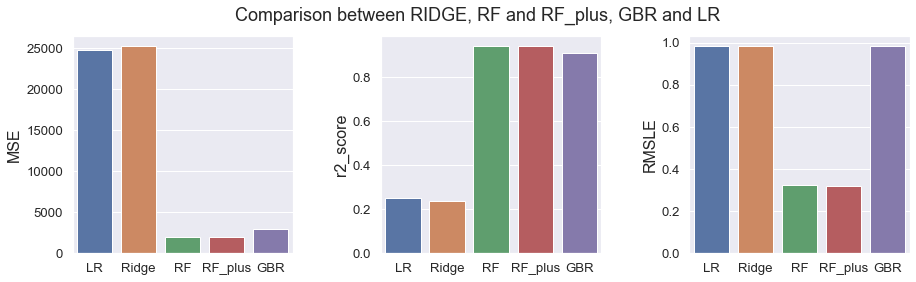

In [109]:
sns.set(font_scale = 1.2)
fig, axs = plt.subplots(1,3, figsize=(15,4))
mseBar = sns.barplot(data=scores_final, x=scores_final.index, y='MSE', ax = axs[0])
r2Bar = sns.barplot(data=scores_final, x=scores_final.index, y='r2_score', ax = axs[1])
rmsleBar = sns.barplot(data=scores_final, x=scores_final.index, y='RMSLE', ax = axs[2])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
fig.suptitle('Comparison between RIDGE, RF and RF_plus, GBR and LR',
            size=18)
axs[0].yaxis.label.set_size(16)
axs[1].yaxis.label.set_size(16)
axs[2].yaxis.label.set_size(16)
 
#mseBar.set_xlabel("X Label",fontsize=30)
#b.set_ylabel("Y Label",fontsize=20)

In [110]:
fig.savefig('./images/models_comparison.png')

## Kaggle submission

In [111]:
X_test = pd.read_csv("./data/test.csv", parse_dates=True, index_col= 0)
#X_test

In [112]:
# extract information from datetime column
X_test['year'] = X_test.index.year
X_test['month'] = X_test.index.month
X_test['week'] = X_test.index.isocalendar().week
X_test['day'] = X_test.index.day
X_test['hour'] = X_test.index.hour
X_test['day_of_week'] = X_test.index.dayofweek

In [113]:
X_test = X_test[ordered_cols]
X_test.shape

(6493, 14)

In [114]:
# train my model with all training data
#model_pipeline.fit(X, logy_plus_1)
#
#grid_search_RF.fit(X, logy_plus_1)
#grid_search_RF_plus.fit(X, logy_plus_1)
grid_GBR_fitted_test = grid_search_GBR.fit(X_t, logy_t)

/home/cubo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.13610084 -0.13458454 -0.10708578 -0.10713496 -0.11881073 -0.11544711
 -0.11301945 -0.11392865 -0.1393865  -0.14075556 -0.10630967 -0.10625802
 -0.11756642 -0.11629033 -0.11105964 -0.11745872         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.13528208 -0.13775391 -0.10688459 -0.10752893 -0.11960928 -0.1192017
 -0.10974174 -0.10830027 -0.14821208 -0.14153113 -0.10709049 -0.10763597
 -0.11856568 -0.11864217 -0.11040104 -0.11263865         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.14310128 -0.13906157 -0.10371022 -0.10555411 -0.11761869 -0.11923033
 -0.11597381 -0.10828553 -0.14580147 -0.14047608 -0.10601613 -0.10492086
 -0.1174498  -0.11611365 -0.11544272 -0.11168287         nan         nan
         nan         nan         nan         nan 

      Iter       Train Loss   Remaining Time 
         1           1.7138            1.27s
         2           1.4387            1.26s
         3           1.2165            1.23s
         4           1.0309            1.21s
         5           0.8807            1.19s
         6           0.7578            1.19s
         7           0.6559            1.17s
         8           0.5699            1.14s
         9           0.4997            1.13s
        10           0.4396            1.11s
        20           0.1720            1.01s
        30           0.1021            0.85s
        40           0.0787            0.72s
        50           0.0664            0.59s


In [115]:
# best parameters
bestPars = grid_GBR_fitted_test.best_params_ 

In [116]:
bestPars

{'columntransformer__bins__n_bins': 6,
 'columntransformer__weekDay*Hour__polynomialfeatures__degree': 2,
 'gradientboostingregressor__alpha': 0.5,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 6,
 'gradientboostingregressor__n_estimators': 100}

In [117]:
#logy_pred_test = model_pipeline.predict(X_test)
#logy_pred_test = grid_search.best_estimator_.predict(X_test)
#logy_pred_test = grid_search_RF_plus.best_estimator_.predict(X_test)
logy_pred_test = grid_GBR_fitted_test.best_estimator_.predict(X_test)
y_pred_test = np.exp(logy_pred_test) - 1

In [118]:
for e in y_pred_test:
    if e < 0:
        print('ATTENTION')
#y_pred_v = np.exp(logy_pred_v) -1

In [119]:
predictedDF = pd.DataFrame({'datetime': X_test.index,
                            'count': y_pred_test.round(0)})

predictedDF.to_csv('AlexBikeRF_GBR_gridSearch.csv', index=False)